In [1]:
import multiprocessing
import numpy as np
import os

import model_based_agent as mba 
import worm_env as we 
#import fake_worm as fw
import utils as ut
import tab_agents as tab
from datetime import datetime 

In [7]:
folder = './Data/Reals'+datetime.now().strftime('%d-%m-%H-%M')
fbase = folder+'/realworm_'+datetime.now().strftime('%d-%m-%H-%M')+'_'
os.mkdir(folder)

num_learners = 2
collection_eps = 2

def combine_learners(learners):
    # Just outputs averaged Q tables, so output is shape [144,2]
    output_shape = [144,2]
    averaged = np.zeros(output_shape)
    for lea in learners:
        averaged += (1/len(learners))*lea.agent.Qtab  
    return averaged

def make_learner_list(dh, num_learners, worm_pars={'num_models':1, 'frac':.5}, **agentpars):
    learners = []
    for i in range(num_learners):
        agent = tab.Q_Alpha_Agent(**agentpars)
        learners.append(mba.Learner(agent, dh, 'a'+str(i), worm_pars=worm_pars))
    return learners

def main():
    '''
    At the end of this function, there will be files in a timestamped folder:
    1. Saved trajectory combined with old
    2. Saved individual trajectory files
    3. Averaged agent from each each full worm episode
    '''

    # Start real worm environment
    worm = we.ProcessedWorm(0,ep_len=10) 
    worm_agent = tab.Q_Alpha_Agent(gamma=0, epsilon=0.05, alpha=0) # Agent doesn't learn
    # Start model environments and learners
    dh = mba.DataHandler()
    dh.load_df('./nogap_traj_df.pkl')
    learners = make_learner_list(dh, num_learners, gamma=0.25, epsilon=0.05, alpha=0.01)
    
    eps_vector = np.ones(2)
    eps_vector[::2] -= .95
    for loop in range(collection_eps):
        # Combining learners from previous run
        worm_agent.Qtab = combine_learners(learners)
        runner = mba.WormRunner(worm, worm_agent)

        # Make new learner list based on newest data
#         learners = make_learner_list(dh, num_learners, 
#                                gamma=0.25, epsilon=0.05, alpha=0.01, q_checkpoint=worm_agent.Qtab)
        
        # Start multiprocessing
        manager = multiprocessing.Manager()
        poison_queue = manager.Queue()
        pool = multiprocessing.Pool()        
        
        # Run main functions: train agents and collect more data
        fname = fbase+str(collection_eps)+'.pkl'
#         lea_outs = []
#         for lea in learners:
#             print('learning')
#             lea_outs.append(pool.apply_async(lea.learn, [], {'learn_limit':100}))
        runner_out = pool.apply_async(runner.full_run, [2, fname], {'eps_vector':eps_vector,'poison_queue':None})
        runner.close()
        pool.close()
        pool.join()
        return runner_out
        # Take new data and add to DataHandler. 
        dh.add_dict_to_df([fname])

    runner.close()
    # Save all new collected data plus old in one dataframe
    dh.save_dfs(fbase+'total.pkl')
    return lea_outs, runner_out
    
if __name__=='__main__':
    lea_outs = main()

In [14]:
if __name__=='__main__':
    #worm = we.ProcessedWorm(0,ep_len=10) 
    worm_agent = tab.Q_Alpha_Agent(gamma=0, epsilon=0.05, alpha=0) # Agent doesn't learn
    runner = mba.WormRunner(worm_agent)
    manager = multiprocessing.Manager()
    poison_queue = manager.Queue()
    pool = multiprocessing.Pool()  
    print('here')
    runner_out = pool.apply_async(runner.full_run, [2])
    pool.close()
    pool.join()
    print('closed')

    #worm.close()

here
closed


In [15]:
runner_out.successful()

True

In [7]:
import matplotlib.pyplot as plt

In [13]:
worm.close()

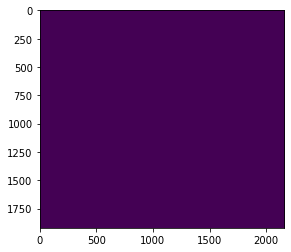

In [16]:
plt.imshow(runner_out.get())

In [10]:
worm = we.ProcessedWorm(0)


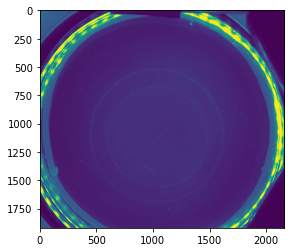

In [12]:
plt.imshow(worm.test_cam())

In [2]:
if __name__=='__main__':
    worm = we.ProcessedWorm(0,ep_len=10) 
    worm_agent = tab.Q_Alpha_Agent(gamma=0, epsilon=0.05, alpha=0) # Agent doesn't learn
    runner = mba.WormRunner(worm_agent)
#     manager = multiprocessing.Manager()
#     poison_queue = manager.Queue()
    pool = ProcessPool()
    print('here')
    runner_out = pool.apipe(runner.full_run, 2,worm)
    #runner.close()
    print('closed')
    pool.close()
    pool.join()
    worm.close()

here
closed


In [1]:
import multiprocessing 
import numpy as np
import os

import model_based_agent as mba 
import worm_env as we 

import utils as ut
import tab_agents as tab
from datetime import datetime 

folder = './Data/Reals'+datetime.now().strftime('%d-%m-%H-%M')
fbase = folder+'/realworm_'
if os.path.isdir(folder):
    os.path.rmdir(folder)
os.mkdir(folder)

num_learners = 5
collection_eps = 6
gamma=.25
epsilon=.05
alpha=.01


if __name__=='__main__':
    
    '''
    At the end of this script, there will be files in a timestamped folder:
    1. Saved trajectory combined with old ('..total.pkl')
    2. Saved individual trajectory files ('..eval_start.pkl', '..[ep].pkl')
    3. Averaged agent from each each full worm episode ('..[ep]_agent.pkl')
    '''

    # Start real worm environment
    worm = we.ProcessedWorm(0,ep_len=1200,bg_time=20) 
    worm_agent = tab.Q_Alpha_Agent(gamma=0, epsilon=0.05, alpha=0) # Agent doesn't learn
    # Start model environments and learners 
    dh = mba.DataHandler()
    dh.load_df('./Data/Reals18-12-15-00/realworm_total.pkl')
    lea_outs = []
    learners = mba.make_learner_list(dh, num_learners, gamma=gamma, epsilon=epsilon, alpha=alpha)
    
    eps_vector = np.ones(6)
    eps_vector[::2] -= .95
    for loop in range(collection_eps):
        fname = fbase+str(loop)+'.pkl'
        
        # Make new learner list based on newest data
        learners = mba.make_learner_list(dh, num_learners, 
                                gamma=gamma, epsilon=epsilon, alpha=alpha, q_checkpoint=worm_agent.Qtab)

        # Start multiprocessing
        manager = multiprocessing.Manager()
        poison_queue = manager.Queue()
        pool = multiprocessing.Pool()
        
        # Run main functions: train agents and collect more data
        lea_outs = []
        for lea in learners:
            print('learning')
            lea_outs.append(pool.apply_async(lea.learn, [],{'learn_limit':1000}))
        # Wait for them to finish
        pool.close()
        pool.join()
        
        # Combining learners from run
        worm_agent.Qtab = mba.combine_learners(lea_outs)
        worm_agent.save(fname[:-4]+'_agent.pkl')
        runner = mba.WormRunner(worm_agent,worm)
        runner.full_run(1, fname, eps_vector=eps_vector)
        
        # Take new data and add to DataHandler. 
        dh.add_dict_to_df([fname])
        # Check if worm is tired
        runner.check_if_tired(fname,active_for=.5)

        
    # Final saves and closes
    worm_agent.Qtab = mba.combine_learners(lea_outs)
    worm_agent.save(fbase+str(collection_eps)+'.pkl')
    runner.close()
    # Save all new collected data plus old in one dataframe
    dh.save_dfs(fbase+'total.pkl')

learning
learning
learning
learning
learning
No kwargs in add_dict_to_df
learning
learning
learning
learning
learning


C:\Users\ccli3\Documents\Research\20_09_07_NewPC\RLWorms\12_01_dropoutmodel\improc.py:205: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


No kwargs in add_dict_to_df
learning
learning
learning
learning
learning
No kwargs in add_dict_to_df
learning
learning
learning
learning
learning
No kwargs in add_dict_to_df
learning
learning
learning
learning
learning
No kwargs in add_dict_to_df
learning
learning
learning
learning
learning
No kwargs in add_dict_to_df


In [3]:
import matplotlib.pyplot as plt

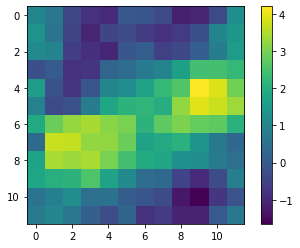

In [8]:
plt.imshow(learners[0].agent.Qtab[:,1].reshape(12,12))
plt.colorbar();

In [11]:
lea_outs[0].get()

(1000, 0.9705171698468558)

In [2]:
quit()

In [2]:
runner.close()